In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import scipy.integrate as spi
import os
import time
import subprocess

from blos_binning_helper import run_wfa_blos, wfa_blos_diff, prep_and_run_cmilos, run_pymilos

import matplotlib as mpl
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

font = {'size'   : 18}

mpl.rcParams['figure.dpi'] = 300
mpl.rc_file_defaults()
plt.rc('font', **font)
mpl.rcParams['image.origin'] = 'lower'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
# mpl.rc('text', usetex=True)
# plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
#mpl.rcParams['text.latex.preamble'] = [r'\boldmath']


mpl.rc('font', **font)

/tmp/ipykernel_63008/2370067691.py:12: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
stokes = fits.getdata("/data/slam/sinjan/1d_200G_syn/6173_masi_theta00/inverted_profs.1.fits")

In [3]:
I = stokes[:,:,0,:].mean(axis=(0,1))
Ic = stokes[:,:,0,:50].mean(axis=(0,1,2))

In [4]:
stokestest = fits.getdata("/export/local/scratch/sinjan/spinor_fwd/ngrey_200G/200000/6173_masi_theta00/inverted_profs.1.fits")

In [5]:
Itest = stokestest[:,:,0,:].mean(axis=(0,1))
Ictest = stokestest[:,:,0,:50].mean(axis=(0,1,2))

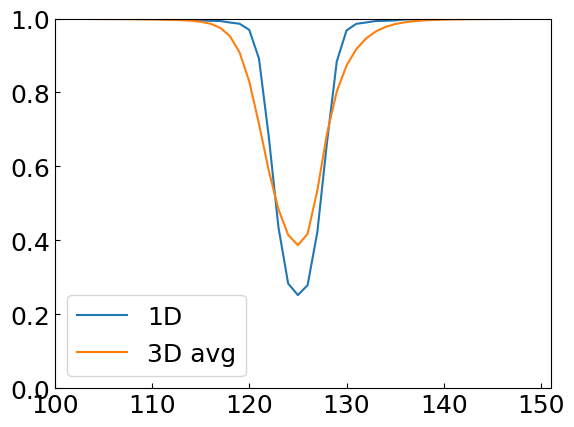

In [6]:
plt.figure()
plt.plot(range(251),I/Ic, label = '1D')
#plt.plot(range(251),stokes[156,30,0,:]/Ic, label = '1D 1 random pixel')
plt.plot(range(251),Itest/Ictest, label = '3D avg')
plt.ylim(0,1)
plt.legend()
plt.xlim(100,151)
plt.show()

In [7]:
v = stokes[:,:,1,:].mean(axis=(0,1))
vtest = stokestest[:,:,1,:].mean(axis=(0,1))

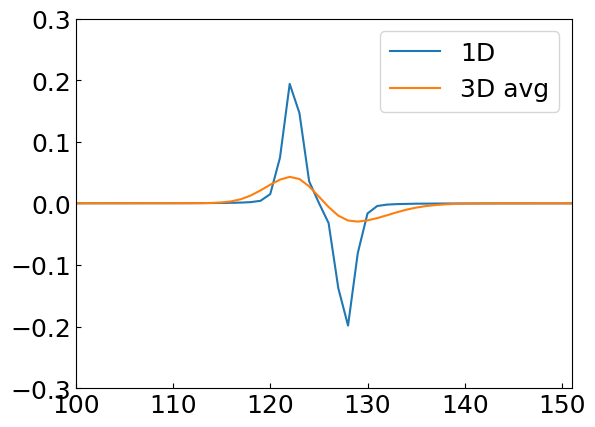

In [8]:
plt.figure()
plt.plot(range(251),v/Ic, label = '1D')
plt.plot(range(251),vtest/Ictest, label = '3D avg')
plt.ylim(-0.3,0.3)
plt.legend()
plt.xlim(100,151)
plt.show()

In [9]:
# apply blos methods to this profile at mu=1 and see what BLOS I retrieve

In [6]:
def get_COG_BLOS(folder,wavelength = 6173.341, dlambda = 0.350):
    
    ddir = f"{folder}"
    stokesv = fits.getdata(ddir + f"/inverted_profs.1.fits")[:,:,1,:].mean(axis=(0,1))
    I = fits.getdata(ddir + f"/inverted_profs.1.fits")[:,:,0,:].mean(axis=(0,1))
    
    RCP = (I + stokesv)
    LCP = (I - stokesv)
    
    I_cont = I[:50].mean()
    
    num_points = 2*1000*dlambda/(14) + 1.0
    assert 1000*dlambda % 14 == 0.0 
    num_points = int(num_points)
    ctr = wavelength
    wavelength_range = np.linspace(ctr - dlambda, ctr + dlambda, num_points)
    idx = int((num_points-1)/2)
    
    nominator_RCP = wavelength_range * (I_cont - RCP[125-idx:125+idx+1])
    denominator_RCP =  (I_cont - RCP[125-idx:125+idx+1])
    RCP_cog = spi.simpson(nominator_RCP, wavelength_range)/spi.simpson(denominator_RCP, wavelength_range)
    
    nominator_LCP = wavelength_range * (I_cont - LCP[125-idx:125+idx+1])
    denominator_LCP =  (I_cont - LCP[125-idx:125+idx+1])
    LCP_cog = spi.simpson(nominator_LCP, wavelength_range)/spi.simpson(denominator_LCP, wavelength_range)
    
    #print(RCP_cog, LCP_cog)
    
    if int(wavelength) == 6173:
        g_Lande = 2.5
    elif int(wavelength) == 5250:
        g_Lande = 3.0
    else:
        print("KWARG Error: wavelength ")
    
    #get centroids of two components
    #in MKSA units
    wavelength = wavelength #needs to be in metres as c is in m/s
    #print(RCP_cog, LCP_cog, RCP_cog-LCP_cog)
    #print(wavelength_range)
    BLOS = abs(RCP_cog - LCP_cog)/2/(4.67e-13*g_Lande*(wavelength**2))
    
    return BLOS

In [11]:
BLOS = get_COG_BLOS("/data/slam/sinjan/1d_200G_syn/6173_masi_theta00/", dlambda = 0.35)
BLOS

196.21869199265217

In [12]:
BLOS

196.21869199265217

In [7]:
blos_cogfields = np.asarray([0]*13)
angles = ['00','25_9','37','45_5','53','60','66_5','72_6','75_5','78_4','81_4','84_2','87_2']
field = '200'

for a,ang in enumerate(angles):
    fold = f'6173_masi_theta{ang}'
    blos_cogfields[a] = get_COG_BLOS(f'/data/slam/sinjan/1d_200G_syn/'+fold, dlambda = 0.35)

In [8]:
blos_cognfields = np.asarray([0]*13)
angles = ['00','-25_9','-37','-45_5','-53','-60','-66_5','-72_6','-75_5','-78_4','-81_4','-84_2','-87_2']
field = '200'

for a,ang in enumerate(angles):
    fold = f'6173_masi_theta{ang}'
    blos_cognfields[a] = get_COG_BLOS(f'/data/slam/sinjan/1d_200G_syn/'+fold, dlambda = 0.35)

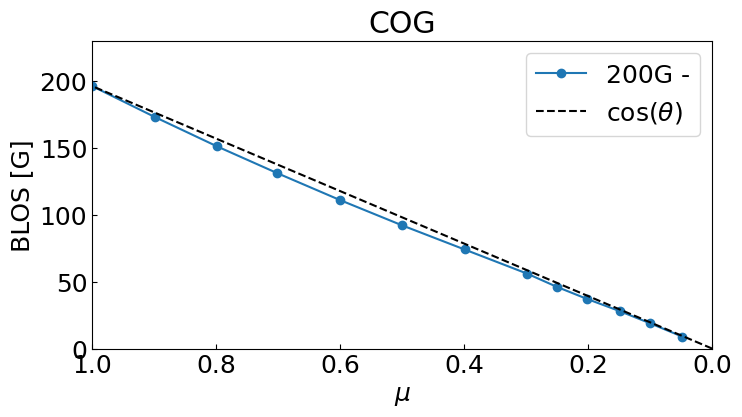

In [15]:
plt.figure(figsize = (8,4))
mu_vals = [0.0486,0.1007,0.1493,0.2014,0.25,0.2986,0.3993,0.5,0.6007,0.7014,0.7986,0.8993,1.0]
plt.plot(mu_vals[::-1], blos_cognfields, label = '200G -', marker = 'o')
#plt.plot(mu_vals[::-1], blos_cogfields, label = '200G +', marker = 'o')
plt.plot(np.linspace(0,1,20),np.linspace(0,blos_cogfields[0],20), '--', color = 'black', label = r'$\cos(\theta)$')
plt.legend()
plt.ylabel("BLOS [G]")
plt.xlabel(r"$\mu$")
plt.title("COG")
plt.ylim(0,230)
plt.xlim(1,0)
plt.show()

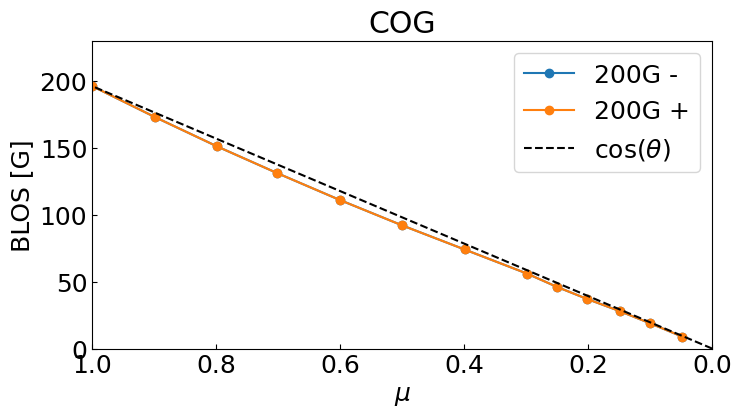

In [16]:
plt.figure(figsize = (8,4))
mu_vals = [0.0486,0.1007,0.1493,0.2014,0.25,0.2986,0.3993,0.5,0.6007,0.7014,0.7986,0.8993,1.0]
plt.plot(mu_vals[::-1], blos_cognfields, label = '200G -', marker = 'o')
plt.plot(mu_vals[::-1], blos_cogfields, label = '200G +', marker = 'o')
plt.plot(np.linspace(0,1,20),np.linspace(0,blos_cogfields[0],20), '--', color = 'black', label = r'$\cos(\theta)$')
plt.legend()
plt.ylabel("BLOS [G]")
plt.xlabel(r"$\mu$")
plt.title("COG")
plt.ylim(0,230)
plt.xlim(1,0)
plt.show()

In [17]:
def linear_lstsq_fit_WFA(folder,wavelength = 6173.341, dlambda = 0.350):
    
    ddir = f"{folder}"
    stokesv = fits.getdata(ddir + f"/inverted_profs.1.fits")[:,:,1,:].mean(axis=(0,1))
    I = fits.getdata(ddir + f"/inverted_profs.1.fits")[:,:,0,:].mean(axis=(0,1))

    dIdlambda = np.gradient(I, 0.014, axis=-1)
    
    num_points = 2*1000*dlambda/(14) + 1.0
    assert 1000*dlambda % 14 == 0.0 
    num_points = int(num_points)
    ctr = wavelength
    wavelength_range = np.linspace(ctr - dlambda, ctr + dlambda, num_points)
    idx = int((num_points-1)/2)
    print(idx)
    
    nominator = np.sum(dIdlambda[125-idx:125+idx+1]*stokesv[125-idx:125+idx+1])
    denominator =  np.sum(dIdlambda[125-idx:125+idx+1]**2)
    
    if int(wavelength) == 6173:
        g_Lande = 2.5
    elif int(wavelength) == 5250:
        g_Lande = 3.0
    else:
        print("KWARG Error: wavelength ")
    
    BLOS = (nominator/denominator) / (4.67e-13*g_Lande*(wavelength**2))
    
    return -BLOS

In [18]:
BLOSWFA = linear_lstsq_fit_WFA("/data/slam/sinjan/1d_200G_syn/", dlambda = 1.75)

125


In [19]:
BLOSWFA

224.87964780688242

In [20]:
data = fits.getdata("/data/slam/sinjan/1d_200G_syn/inverted_profs.1.fits")[:,:,[0,2,3,1],:]
#data = fits.getdata(f"{default_dir}/{folder}/{snapshot}/6173_masi_theta{angle}/inverted_profs.1.fits")
testwfa = run_wfa_blos(data, dlambda=0.35, refwv=6173.341, return_mean=True)

100
151


In [21]:
testwfa

225.06516

In [22]:
blos_wfafieldst = [0]*13
angles = ['00','25_9','37','45_5','53','60','66_5','72_6','75_5','78_4','81_4','84_2','87_2']
field = '200'

for a,ang in enumerate(angles):
    fold = f'6173_masi_theta{ang}'
    data = fits.getdata(f"/data/slam/sinjan/1d_200G_syn/{fold}/inverted_profs.1.fits")[:,:,[0,2,3,1],:]
    blos_wfafieldst[a] = run_wfa_blos(data, dlambda=0.35, refwv=6173.341, return_mean=True)

100
151
100
151
100
151
100
151
100
151
100
151
100
151
100
151
100
151
100
151
100
151
100
151
100
151


In [23]:
blos_wfafieldst

[225.064,
 199.89124,
 175.41747,
 152.44289,
 129.26964,
 106.59645,
 84.2721,
 62.247005,
 51.77648,
 41.460144,
 30.59482,
 20.60895,
 10.03312]

In [9]:
blos_wfafields = [0]*13
angles = ['00','25_9','37','45_5','53','60','66_5','72_6','75_5','78_4','81_4','84_2','87_2']
field = '200'

for a,ang in enumerate(angles):
    fold = f'6173_masi_theta{ang}'
    data = fits.getdata(f"/data/slam/sinjan/1d_200G_syn/{fold}/inverted_profs.1.fits")[:,:,[0,2,3,1],:]
    blos_wfafields[a] = wfa_blos_diff(data, dlambda=0.35, refwv=6173.341, return_mean=True)

100
151
100
151
100
151
100
151
100
151
100
151
100
151
100
151
100
151
100
151
100
151
100
151
100
151


In [10]:
blos_wfanfields = [0]*13
angles = ['00','-25_9','-37','-45_5','-53','-60','-66_5','-72_6','-75_5','-78_4','-81_4','-84_2','-87_2']
field = '200'

for a,ang in enumerate(angles):
    fold = f'6173_masi_theta{ang}'
    data = fits.getdata(f"/data/slam/sinjan/1d_200G_syn/{fold}/inverted_profs.1.fits")[:,:,[0,2,3,1],:]
    blos_wfanfields[a] = wfa_blos_diff(data, dlambda=0.35, refwv=6173.341, return_mean=True)

100
151
100
151
100
151
100
151
100
151
100
151
100
151
100
151
100
151
100
151
100
151
100
151
100
151


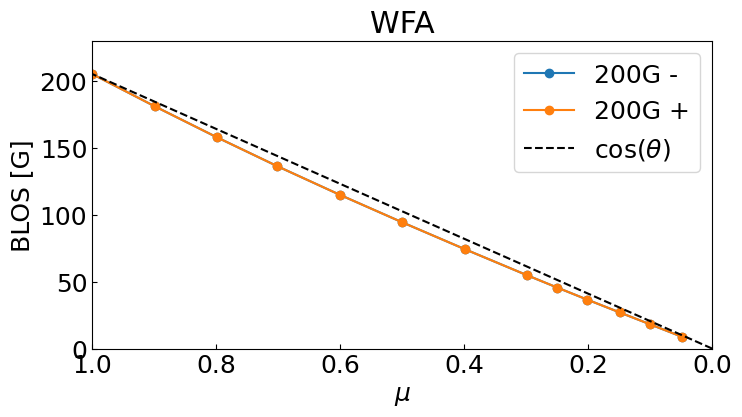

In [26]:
plt.figure(figsize = (8,4))
mu_vals = [0.0486,0.1007,0.1493,0.2014,0.25,0.2986,0.3993,0.5,0.6007,0.7014,0.7986,0.8993,1.0]
plt.plot(mu_vals[::-1], blos_wfanfields, label = '200G -', marker = 'o')
plt.plot(mu_vals[::-1], blos_wfafields, label = '200G +', marker = 'o')
plt.plot(np.linspace(0,1,20),np.linspace(0,blos_wfafields[0],20), '--', color = 'black', label = r'$\cos(\theta)$')
plt.legend()
plt.ylabel("BLOS [G]")
plt.xlabel(r"$\mu$")
plt.title("WFA")
plt.ylim(0,230)
plt.xlim(1,0)
plt.show()

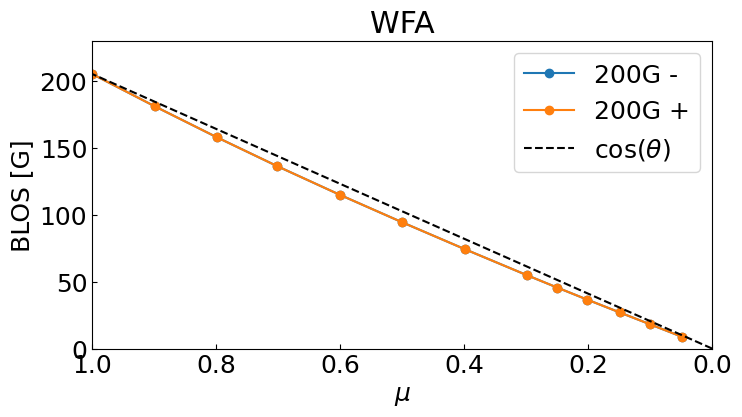

In [27]:
plt.figure(figsize = (8,4))
mu_vals = [0.0486,0.1007,0.1493,0.2014,0.25,0.2986,0.3993,0.5,0.6007,0.7014,0.7986,0.8993,1.0]
plt.plot(mu_vals[::-1], blos_wfanfields, label = '200G -', marker = 'o')
plt.plot(mu_vals[::-1], blos_wfafields, label = '200G +', marker = 'o')
plt.plot(np.linspace(0,1,20),np.linspace(0,blos_wfafields[0],20), '--', color = 'black', label = r'$\cos(\theta)$')
plt.legend()
plt.ylabel("BLOS [G]")
plt.xlabel(r"$\mu$")
plt.title("WFA")
plt.ylim(0,230)
plt.xlim(1,0)
plt.show()

In [11]:
def run_cmilos(data,wave_axis,rte,options = [6,15],out_dir = './', loc = 'cmilos/'):
    
    """
    RTE inversion using CMILOS
    """
    #print(" ")
    #print('-->>>>>>> RUNNING CMILOS ')
    
    try:
        CMILOS_LOC = "/scratch/slam/sinjan/true_flux_project/" + loc

        if os.path.isfile(CMILOS_LOC+'milos'):
            pass#print("Cmilos executable located at:", CMILOS_LOC)

        else:
            raise ValueError('Cannot find cmilos:', CMILOS_LOC)

    except ValueError as err:
        print(err.args[0])
        print(err.args[1])
        return        
    
    start_time = time.perf_counter()

    #print(wave_axis,color = bcolors.WARNING)
    #print("Wave axis is: ", (wave_axis - wavelength)*1000.)
    #print('Saving data into dummy_in.txt for RTE input')

    if data.ndim == 4:
        sdata = data
    elif data.ndim != 4:
        print("Incorrect dimensions of 'data' array")
        exit()
    y,x,p,l = sdata.shape
    #print(y,x,p,l)
    
    filename = out_dir + 'dummy_in.txt'
    with open(filename,"w") as f:
        for i in range(x):
            for j in range(y):
                for k in range(l):
                    f.write('%e %e %e %e %e \n' % (wave_axis[k],sdata[j,i,0,k],sdata[j,i,1,k],sdata[j,i,2,k],sdata[j,i,3,k])) #wv, I, Q, U, V

    #print(f'  ---- >>>>> Inverting data: .... ')

    cmd = CMILOS_LOC+"./milos"

    if rte == 'RTE':
        rte_on = subprocess.call(cmd+" "+str(options[0])+" "+str(options[1])+f" 0 0 {out_dir+'dummy_in.txt'}  >  {out_dir+'dummy_out.txt'}",shell=True)
    if rte == 'CE':
        rte_on = subprocess.call(cmd+" "+str(options[0])+" "+str(options[1])+f" 2 0 {out_dir+'dummy_in.txt'}  >  {out_dir+'dummy_out.txt'}",shell=True)
    if rte == 'CE+RTE':
        rte_on = subprocess.call(cmd+" "+str(options[0])+" "+str(options[1])+f" 1 0 {out_dir+'dummy_in.txt'}  >  {out_dir+'dummy_out.txt'}",shell=True)

    #print('  ---- >>>>> Reading results.... ')
    del_dummy = subprocess.call(f"rm {out_dir + 'dummy_in.txt'}",shell=True)

    with open(out_dir+'dummy_out.txt') as f:
        pass
        #print(f.readline().strip('\n'))

    res = np.loadtxt(out_dir+'dummy_out.txt',skiprows=1)
    npixels = res.shape[0]/12.
    #print(npixels)
    #print(npixels/x)
    result = np.zeros((12,y*x)).astype(float)
    rte_invs = np.zeros((12,y,x)).astype(float)
    for i in range(y*x):
        result[:,i] = res[i*12:(i+1)*12]
    result = result.reshape(12,x,y)
    result = np.einsum('ijk->ikj', result)
    _ = subprocess.call(f"rm {out_dir+'dummy_out.txt'}",shell=True)
    
    #print(f"CMILOS RTE Inversion Run Time: {np.round(time.perf_counter() - start_time,3)} seconds ")
    
    return result

In [12]:
def get_cmilos_blos(folder,dlambda):
    data = fits.getdata(f"{folder}/inverted_profs.1.fits").mean(axis = (0,1))
    data = np.vstack([data[0,:],data[2,:],data[3,:],data[1,:]])
    #data[1,:] = 0 #set Q=0
    #data[2,:] = 0 #set U=0
    Ic = data[0,100].mean()
    data = data/Ic
    num_points = int(2*1000*dlambda/(14) + 1.0)
    data = data[:,125-int((num_points-1)/2):126+int((num_points-1)/2)] #was originally hardcoded to 110:141
    print(f"Start wv index: {125-int((num_points-1)/2)}")
    print(f"End wv index: {126+int((num_points-1)/2)}") #-210,+210
    data = np.expand_dims(data,[0,1])
    
    wavelengths = np.linspace(6173.341-dlambda,6173.341+dlambda,num_points)
    result = run_cmilos(data, wavelengths, 'CE+RTE', options = [num_points,15], out_dir = './', loc = 'cmilos_1551/')
    blos = result[2,:,:]*np.cos(result[3,:,:]*np.pi/180.)
    return blos[0][0]

In [30]:
cmilosblos = get_cmilos_blos("/data/slam/sinjan/1d_200G_syn/",dlambda = 0.35)

Start wv index: 100
End wv index: 151


In [31]:
cmilosblos

200.7316960844013

In [32]:
data = fits.getdata("/data/slam/sinjan/1d_200G_syn/inverted_profs.1.fits")[:,:,[0,2,3,1],:]
#data = fits.getdata(f"{default_dir}/{folder}/{snapshot}/6173_masi_theta{angle}/inverted_profs.1.fits")
testcmilos = prep_and_run_cmilos(data, '1d_200G_syn', '00', '1', dlambda=0.35, refwv=6173.341, return_mean=True, niter=15)

Start wv index: 100
End wv index: 151

(288, 288, 4, 51)


In [33]:
testcmilos

200.71507334357878

In [13]:
blos_fields = [0]*13
angles = ['00','25_9','37','45_5','53','60','66_5','72_6','75_5','78_4','81_4','84_2','87_2']
field = '200'

for a,ang in enumerate(angles):
    fold = f'6173_masi_theta{ang}'
    blos_fields[a] = get_cmilos_blos(f'/data/slam/sinjan/1d_200G_syn/'+fold, dlambda = 0.35)

Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151


In [14]:
blos_qfields = [0]*13
angles = ['00','25_9','37','45_5','53','60','66_5','72_6','75_5','78_4','81_4','84_2','87_2']
field = '200'

for a,ang in enumerate(angles):
    fold = f'6173_masi_theta{ang}'
    blos_qfields[a] = get_cmilos_blos(f'/data/slam/sinjan/1d_200G_syn/'+fold, dlambda = 0.35)

Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151


In [22]:
blos_nfields = [0]*13
angles = ['00','-25_9','-37','-45_5','-53','-60','-66_5','-72_6','-75_5','-78_4','-81_4','-84_2','-87_2']
field = '200'

for a,ang in enumerate(angles):
    fold = f'6173_masi_theta{ang}'
    blos_nfields[a] = get_cmilos_blos(f'/data/slam/sinjan/1d_200G_syn/'+fold, dlambda = 0.35)

Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151


In [15]:
blos_qnfields = [0]*13
angles = ['00','-25_9','-37','-45_5','-53','-60','-66_5','-72_6','-75_5','-78_4','-81_4','-84_2','-87_2']
field = '200'

for a,ang in enumerate(angles):
    fold = f'6173_masi_theta{ang}'
    blos_qnfields[a] = get_cmilos_blos(f'/data/slam/sinjan/1d_200G_syn/'+fold, dlambda = 0.35)

Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151
Start wv index: 100
End wv index: 151


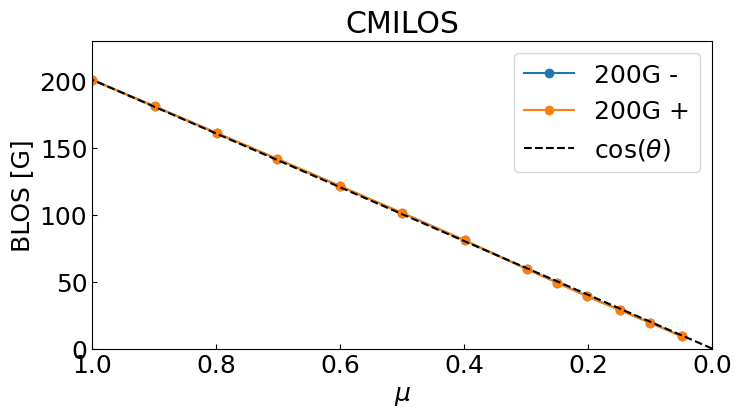

In [38]:
plt.figure(figsize = (8,4))
mu_vals = [0.0486,0.1007,0.1493,0.2014,0.25,0.2986,0.3993,0.5,0.6007,0.7014,0.7986,0.8993,1.0]
plt.plot(mu_vals[::-1], blos_qnfields, label = '200G -', marker = 'o')
plt.plot(mu_vals[::-1], blos_qfields, label = '200G +', marker = 'o')
plt.plot(np.linspace(0,1,20),np.linspace(0,blos_fields[0],20), '--', color = 'black', label = r'$\cos(\theta)$')
plt.legend()
plt.ylabel("BLOS [G]")
plt.xlabel(r"$\mu$")
plt.title("CMILOS")
plt.ylim(0,230)
plt.xlim(1,0)
plt.show()

In [39]:
blos_pfields = [0]*13
angles = ['00','25_9','37','45_5','53','60','66_5','72_6','75_5','78_4','81_4','84_2','87_2']
field = '200'

for a,ang in enumerate(angles):
    fold = f'6173_masi_theta{ang}/'
    data = np.expand_dims(fits.getdata(f'/data/slam/sinjan/1d_200G_syn/'+fold+'inverted_profs.1.fits')[:,:,[0,2,3,1],:].mean(axis=(0,1)), axis=(0,1))
    Ic = data[:,:,0,100].mean()
    print(data.shape)
    blos_pfields[a] = run_pymilos(data/Ic, 0.35, 6173.341, True, weight=[1,1,1,1], \
                                   initial_model=[400.,30.,120.,10.,0.05,1.5,0.01,0.22,0.85], \
                                   niter=15)

(1, 1, 4, 251)
Options [in pymilos]:  [51 15  1  0  0  0  0  0  0]
input_data shape [in pymilos]:  1 4 51
------ flattened:  (204,)
Weights  [in pymilos]:  [1. 1. 1. 1.]
Initial Model  [in pymilos]:  [4.0e+02 3.0e+01 1.2e+02 1.0e+01 5.0e-02 1.5e+00 1.0e-02 2.2e-01 8.5e-01]
(1, 1, 4, 251)
Options [in pymilos]:  [51 15  1  0  0  0  0  0  0]
input_data shape [in pymilos]:  1 4 51
------ flattened:  (204,)
Weights  [in pymilos]:  [1. 1. 1. 1.]
Initial Model  [in pymilos]:  [4.0e+02 3.0e+01 1.2e+02 1.0e+01 5.0e-02 1.5e+00 1.0e-02 2.2e-01 8.5e-01]
(1, 1, 4, 251)
Options [in pymilos]:  [51 15  1  0  0  0  0  0  0]
input_data shape [in pymilos]:  1 4 51
------ flattened:  (204,)
Weights  [in pymilos]:  [1. 1. 1. 1.]
Initial Model  [in pymilos]:  [4.0e+02 3.0e+01 1.2e+02 1.0e+01 5.0e-02 1.5e+00 1.0e-02 2.2e-01 8.5e-01]
(1, 1, 4, 251)
Options [in pymilos]:  [51 15  1  0  0  0  0  0  0]
input_data shape [in pymilos]:  1 4 51
------ flattened:  (204,)
Weights  [in pymilos]:  [1. 1. 1. 1.]
Initial 

In [40]:
blos_pnfields = [0]*13
angles = ['00','-25_9','-37','-45_5','-53','-60','-66_5','-72_6','-75_5','-78_4','-81_4','-84_2','-87_2']
field = '200'

for a,ang in enumerate(angles):
    fold = f'6173_masi_theta{ang}/'
    data = np.expand_dims(fits.getdata(f'/data/slam/sinjan/1d_200G_syn/'+fold+'inverted_profs.1.fits')[:,:,[0,2,3,1],:].mean(axis=(0,1)), axis=(0,1))
    Ic = data[:,:,0,100].mean()
    print(data.shape)
    blos_pnfields[a] = run_pymilos(data/Ic, 0.35, 6173.341, True, weight=[1,1,1,1], \
                                   initial_model=[400.,30.,120.,10.,0.05,1.5,0.01,0.22,0.85], \
                                   niter=15)

(1, 1, 4, 251)
Options [in pymilos]:  [51 15  1  0  0  0  0  0  0]
input_data shape [in pymilos]:  1 4 51
------ flattened:  (204,)
Weights  [in pymilos]:  [1. 1. 1. 1.]
Initial Model  [in pymilos]:  [4.0e+02 3.0e+01 1.2e+02 1.0e+01 5.0e-02 1.5e+00 1.0e-02 2.2e-01 8.5e-01]
(1, 1, 4, 251)
Options [in pymilos]:  [51 15  1  0  0  0  0  0  0]
input_data shape [in pymilos]:  1 4 51
------ flattened:  (204,)
Weights  [in pymilos]:  [1. 1. 1. 1.]
Initial Model  [in pymilos]:  [4.0e+02 3.0e+01 1.2e+02 1.0e+01 5.0e-02 1.5e+00 1.0e-02 2.2e-01 8.5e-01]
(1, 1, 4, 251)
Options [in pymilos]:  [51 15  1  0  0  0  0  0  0]
input_data shape [in pymilos]:  1 4 51
------ flattened:  (204,)
Weights  [in pymilos]:  [1. 1. 1. 1.]
Initial Model  [in pymilos]:  [4.0e+02 3.0e+01 1.2e+02 1.0e+01 5.0e-02 1.5e+00 1.0e-02 2.2e-01 8.5e-01]
(1, 1, 4, 251)
Options [in pymilos]:  [51 15  1  0  0  0  0  0  0]
input_data shape [in pymilos]:  1 4 51
------ flattened:  (204,)
Weights  [in pymilos]:  [1. 1. 1. 1.]
Initial 

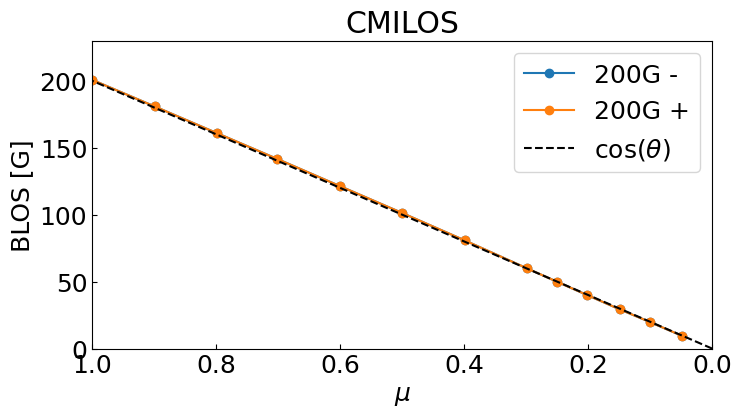

In [41]:
plt.figure(figsize = (8,4))
mu_vals = [0.0486,0.1007,0.1493,0.2014,0.25,0.2986,0.3993,0.5,0.6007,0.7014,0.7986,0.8993,1.0]
plt.plot(mu_vals[::-1], blos_pnfields, label = '200G -', marker = 'o')
plt.plot(mu_vals[::-1], blos_pfields, label = '200G +', marker = 'o')
plt.plot(np.linspace(0,1,20),np.linspace(0,200,20), '--', color = 'black', label = r'$\cos(\theta)$')
plt.legend()
plt.ylabel("BLOS [G]")
plt.xlabel(r"$\mu$")
plt.title("CMILOS")
plt.ylim(0,230)
plt.xlim(1,0)
plt.show()

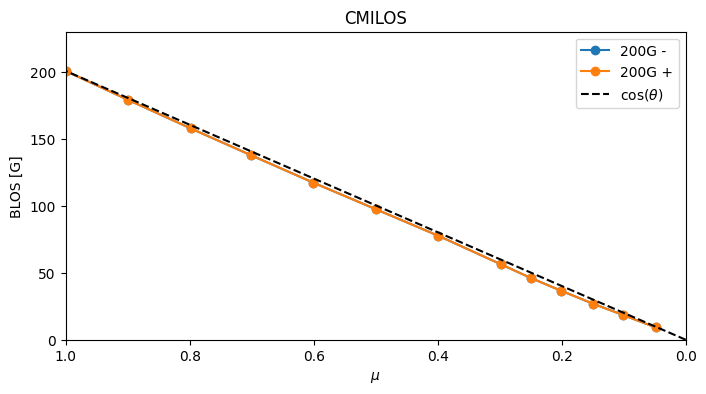

In [7]:
plt.figure(figsize = (8,4))
mu_vals = [0.0486,0.1007,0.1493,0.2014,0.25,0.2986,0.3993,0.5,0.6007,0.7014,0.7986,0.8993,1.0]
plt.plot(mu_vals[::-1], blos_nfields, label = '200G -', marker = 'o')
plt.plot(mu_vals[::-1], blos_fields, label = '200G +', marker = 'o')
plt.plot(np.linspace(0,1,20),np.linspace(0,blos_fields[0],20), '--', color = 'black', label = r'$\cos(\theta)$')
plt.legend()
plt.ylabel("BLOS [G]")
plt.xlabel(r"$\mu$")
plt.title("CMILOS")
plt.ylim(0,230)
plt.xlim(1,0)
plt.show()

In [43]:
(np.asarray(blos_nfields) - np.asarray(mu_vals[::-1])*200)/(np.asarray(mu_vals[::-1])*200)*100
(np.asarray(blos_fields) - np.asarray(mu_vals[::-1])*200)/(np.asarray(mu_vals[::-1])*200)*100

array([ 0.36584651,  0.54151046,  0.70978139,  0.9443916 ,  1.04008503,
        1.26889755,  1.19650583, -0.59427092, -1.40768125, -3.23603784,
       -3.26120272, -3.60977332, -5.94706771])

In [44]:
np.mean((np.asarray(blos_fields) - np.asarray(mu_vals[::-1])*200)/(np.asarray(mu_vals[::-1])*200)*100)

-0.9222319536438287

In [45]:
np.std((np.asarray(blos_fields) - np.asarray(mu_vals[::-1])*200)/(np.asarray(mu_vals[::-1])*200)*100)

2.265625734563799

In [16]:
def get_mdi_blos(folder, T = 0.42):
    stokesv = fits.getdata(f"{folder}/inverted_profs.1.fits")[:,:,1,:].mean(axis=(0,1))
    I = fits.getdata(f"{folder}/inverted_profs.1.fits")[:,:,0,:].mean(axis=(0,1))
    Ic = fits.getdata(f"{folder}/inverted_profs.1.fits")[:,:,0,:50].mean(axis=(0,1,2))
    stokesv /= Ic
    I /= Ic
    
    RCP = (I + stokesv)/2
    LCP = (I - stokesv)/2
    
    T_width = T*1000/2/14 #T in AA
    assert T_width.is_integer()
    T_width = int(T_width)
    
    num_samples = int(T_width*2 + 1)
    x = np.linspace(-T/2,T/2,num_samples)
    central_idx = 125
    PI_FAC = 2

    ya_LCP = LCP[central_idx-T_width:central_idx+T_width+1]*np.cos(PI_FAC*np.pi*x/T)
    yb_LCP = LCP[central_idx-T_width:central_idx+T_width+1]*np.sin(PI_FAC*np.pi*x/T)

    ya_RCP = RCP[central_idx-T_width:central_idx+T_width+1]*np.cos(PI_FAC*np.pi*x/T)
    yb_RCP = RCP[central_idx-T_width:central_idx+T_width+1]*np.sin(PI_FAC*np.pi*x/T)

    a_1l = 2/T * spi.simpson(ya_LCP)
    b_1l = 2/T * spi.simpson(yb_LCP)

    a_1r = 2/T * spi.simpson(ya_RCP)
    b_1r = 2/T * spi.simpson(yb_RCP)
    
    dv_dx = 48562.4 #m/s/AA
    
    V_RCP = dv_dx * T / (PI_FAC*np.pi) * np.arctan(b_1r/a_1r)
    V_LCP = dv_dx * T / (PI_FAC*np.pi) * np.arctan(b_1l/a_1l)
    
    K_m = 0.231 #Gs/m
    
    V = ( V_RCP + V_LCP ) / 2
    BLOS = -( V_LCP - V_RCP ) * K_m
    
    return BLOS

In [47]:
mdiblos = get_mdi_blos("/data/slam/sinjan/1d_200G_syn/",T = 0.7)

In [48]:
mdiblos

195.4170000122551

In [17]:
blos_mfields = [0]*13
angles = ['00','25_9','37','45_5','53','60','66_5','72_6','75_5','78_4','81_4','84_2','87_2']
field = '200'

for a,ang in enumerate(angles):
    fold = f'6173_masi_theta{ang}'
    blos_mfields[a] = get_mdi_blos(f'/data/slam/sinjan/1d_200G_syn/'+fold, T = 0.7)

In [18]:
blos_mnfields = [0]*13
angles = ['00','-25_9','-37','-45_5','-53','-60','-66_5','-72_6','-75_5','-78_4','-81_4','-84_2','-87_2']
field = '200'

for a,ang in enumerate(angles):
    fold = f'6173_masi_theta{ang}'
    blos_mnfields[a] = get_mdi_blos(f'/data/slam/sinjan/1d_200G_syn/'+fold, T = 0.7)

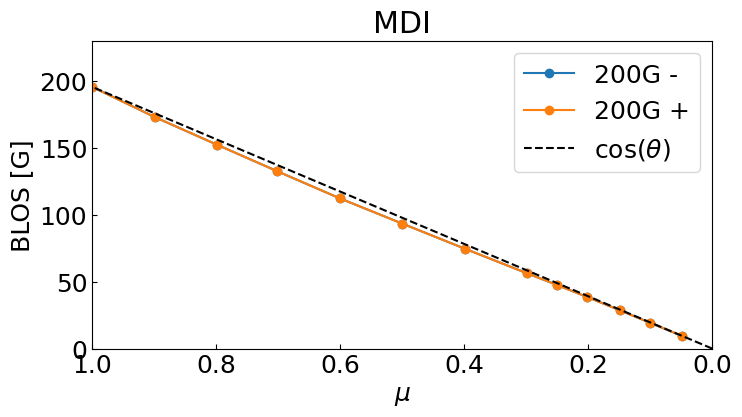

In [51]:
plt.figure(figsize = (8,4))
mu_vals = [0.0486,0.1007,0.1493,0.2014,0.25,0.2986,0.3993,0.5,0.6007,0.7014,0.7986,0.8993,1.0]
plt.plot(mu_vals[::-1], blos_mnfields, label = '200G -', marker = 'o')
plt.plot(mu_vals[::-1], blos_mfields, label = '200G +', marker = 'o')
plt.plot(np.linspace(0,1,20),np.linspace(0,blos_mfields[0],20), '--', color = 'black', label = r'$\cos(\theta)$')
plt.legend()
plt.ylabel("BLOS [G]")
plt.xlabel(r"$\mu$")
plt.title("MDI")
plt.ylim(0,230)
plt.xlim(1,0)
plt.show()

In [52]:
(np.asarray(blos_mnfields) - np.asarray(mu_vals[::-1])*200)/(np.asarray(mu_vals[::-1])*200)*100
np.mean((np.asarray(blos_mfields) - np.asarray(mu_vals[::-1])*200)/(np.asarray(mu_vals[::-1])*200)*100)

-4.781557327806149

In [53]:
np.std((np.asarray(blos_mfields) - np.asarray(mu_vals[::-1])*200)/(np.asarray(mu_vals[::-1])*200)*100)

1.3579927736063553

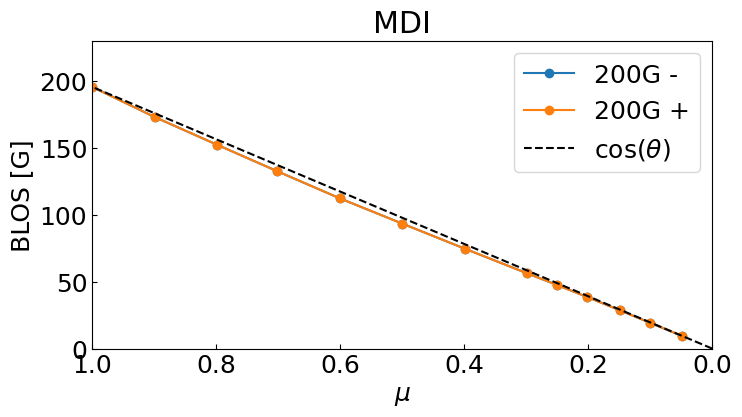

In [54]:
plt.figure(figsize = (8,4))
mu_vals = [0.0486,0.1007,0.1493,0.2014,0.25,0.2986,0.3993,0.5,0.6007,0.7014,0.7986,0.8993,1.0]
plt.plot(mu_vals[::-1], blos_mnfields, label = '200G -', marker = 'o')
plt.plot(mu_vals[::-1], blos_mfields, label = '200G +', marker = 'o')
plt.plot(np.linspace(0,1,20),np.linspace(0,blos_mfields[0],20), '--', color = 'black', label = r'$\cos(\theta)$')
plt.legend()
plt.ylabel("BLOS [G]")
plt.xlabel(r"$\mu$")
plt.title("MDI")
plt.ylim(0,230)
plt.xlim(1,0)
plt.show()

In [55]:
mu_lim=11
blos_fields[:mu_lim]

[200.73169302778945,
 180.83396070605173,
 160.85366282917695,
 141.6047925302793,
 121.38955816002945,
 101.26889754716524,
 80.81552955800198,
 59.3651014064303,
 49.29615937379925,
 38.97652395670404,
 28.886204867981448]

In [20]:
from matplotlib.gridspec import GridSpec

In [86]:
np.array(blos_pfields[:mu_lim])-np.array(blos_qfields[:mu_lim])

array([-4.43303404e-02,  6.95276862e-04,  1.22058652e-04, -3.28414061e-04,
       -2.23599493e-04,  1.86297747e-05,  2.25040137e-02,  5.43917524e-01,
        5.77090167e-01,  9.46275615e-01,  4.49825962e-01])

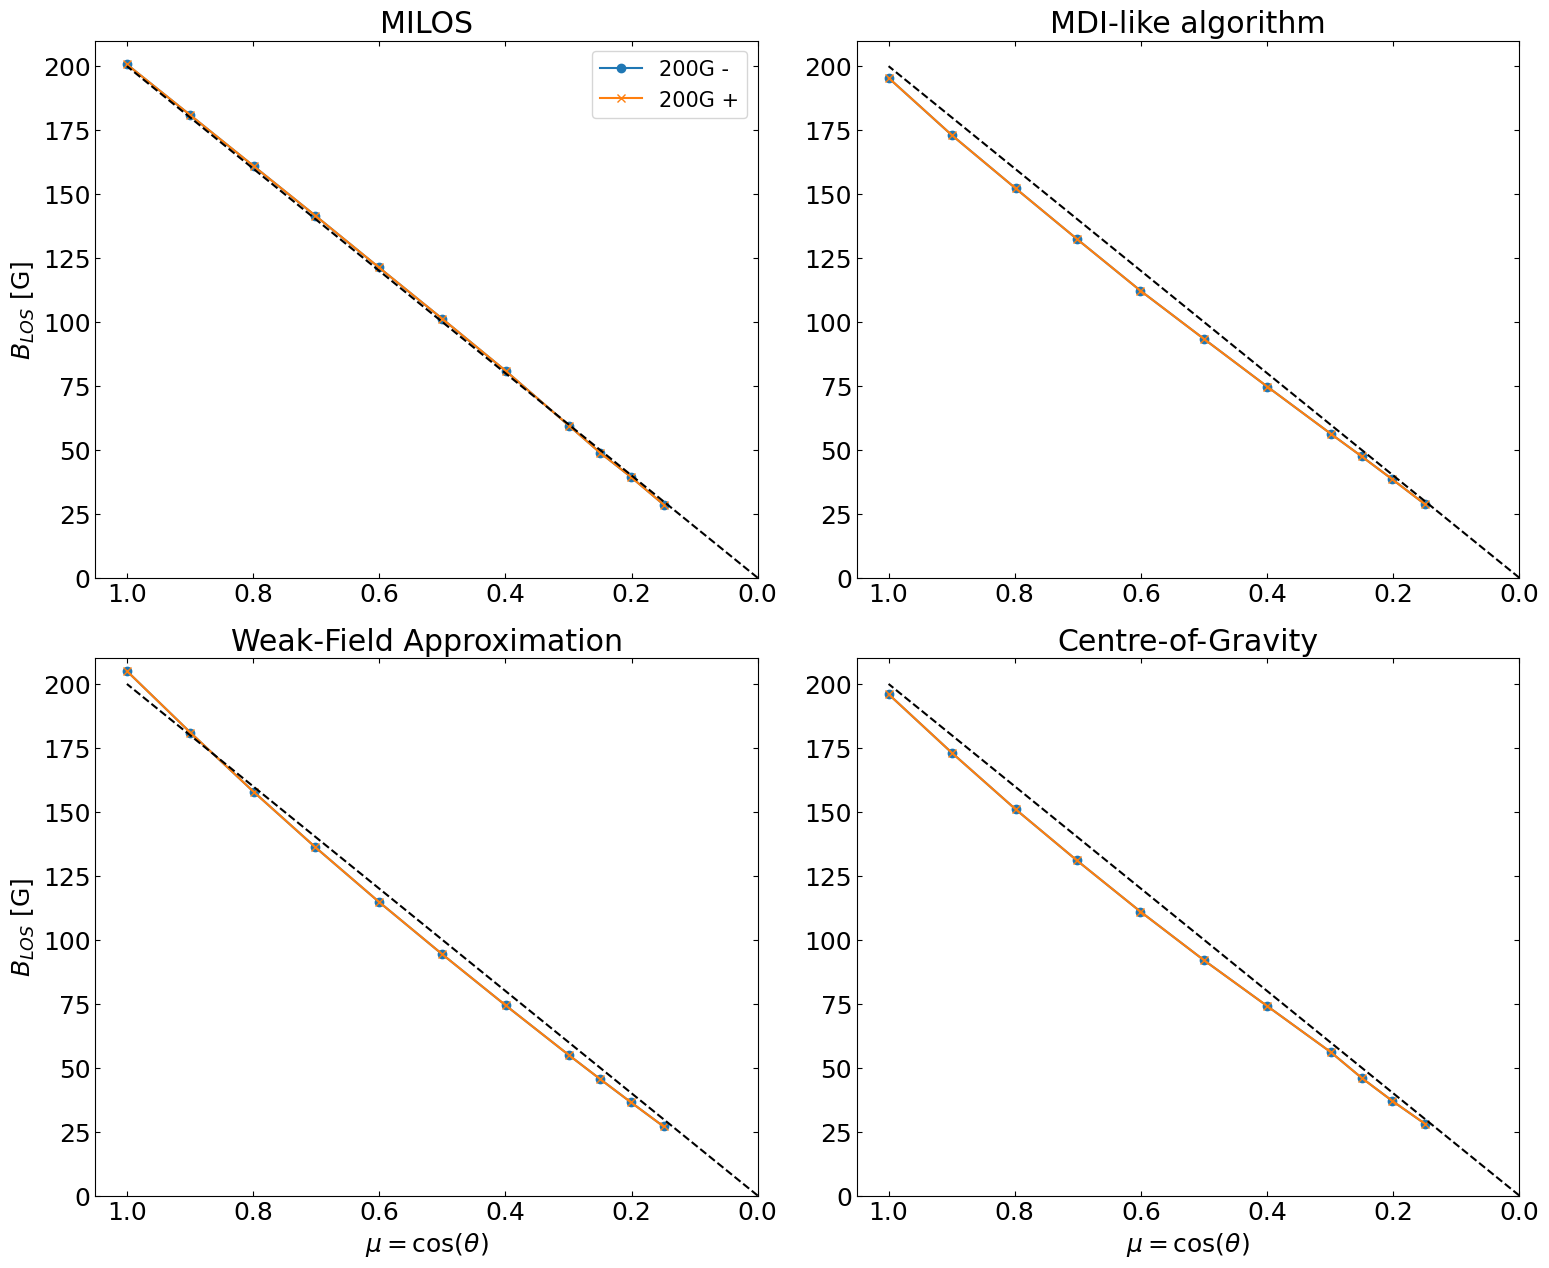

In [24]:
fig = plt.figure(figsize=(16,15))

mu_vals = [0.0486,0.1007,0.1493,0.2014,0.25,0.2986,0.3993,0.5,0.6007,0.7014,0.7986,0.8993,1.0]
mu_lim = -2

gs2 = GridSpec(2, 2, left=0.1, right=0.99, hspace=0.15,wspace=0.15)

ax2 = fig.add_subplot(gs2[0, 0])
#x2.set_aspect('equal')
ax2.set_ylabel(r"$B_{LOS}$ [G]")
ax2.set_title("MILOS")
ax2.plot(mu_vals[::-1][:mu_lim], blos_nfields[:mu_lim], label = '200G -', marker = 'o')
ax2.plot(mu_vals[::-1][:mu_lim], blos_fields[:mu_lim], label = '200G +', marker = 'x')
ax2.plot(np.linspace(0,1,20),np.linspace(0,200,20), '--', color = 'black')
ax2.legend(fontsize=15)
ax2.set_ylim(0,210)
ax2.set_xlim(1.05,0)
ax2.tick_params(top=True, bottom=True, left=True, right=True, labeltop=False, labelbottom=True, direction="in")


ax3 = fig.add_subplot(gs2[0, 1])
#ax3.set_aspect('equal')
ax3.set_title("MDI-like algorithm")
ax3.plot(mu_vals[::-1][:mu_lim], blos_mnfields[:mu_lim], label = '200G -', marker = 'o')
ax3.plot(mu_vals[::-1][:mu_lim], blos_mfields[:mu_lim], label = '200G +', marker = 'x')
ax3.plot(np.linspace(0,1,20),np.linspace(0,200,20), '--', color = 'black')#, label = r'$200\times\mu$')
#ax3.legend()
ax3.tick_params(top=True, bottom=True, left=True, right=True, labeltop=False, labelbottom=True, direction="in")
ax3.set_ylim(0,210)
ax3.set_xlim(1.05,0)

ax4 = fig.add_subplot(gs2[1, 0])
#ax4.set_aspect('equal')
ax4.set_ylabel(r"$B_{LOS}$ [G]")
ax4.set_xlabel(r"$\mu=\cos(\theta)$")
ax4.set_title("Weak-Field Approximation")
ax4.plot(mu_vals[::-1][:mu_lim], blos_wfanfields[:mu_lim], label = '200G -', marker = 'o')
ax4.plot(mu_vals[::-1][:mu_lim], blos_wfafields[:mu_lim], label = '200G +', marker = 'x')
ax4.plot(np.linspace(0,1,20),np.linspace(0,200,20), '--', color = 'black')#, label = r'$200\times\mu$')
#ax4.legend()
ax4.tick_params(top=True, bottom=True, left=True, right=True, labeltop=False, labelbottom=True, direction="in")
ax4.set_ylim(0,210)
ax4.set_xlim(1.05,0)


ax5 = fig.add_subplot(gs2[1, 1])
ax5.set_xlabel(r"$\mu=\cos(\theta)$")
ax5.set_title("Centre-of-Gravity")
ax5.plot(mu_vals[::-1][:mu_lim], blos_cognfields[:mu_lim], label = '200G -', marker = 'o')
ax5.plot(mu_vals[::-1][:mu_lim], blos_cogfields[:mu_lim], label = '200G +', marker = 'x')
ax5.plot(np.linspace(0,1,20),np.linspace(0,200,20), '--', color = 'black')#, label = r'$200\times\mu$')
ax5.tick_params(top=True, bottom=True, left=True, right=True, labeltop=False, labelbottom=True, direction="in")
ax5.set_ylim(0,210)
ax5.set_xlim(1.05,0)
#ax5.legend()
#plt.tight_layout()
plt.savefig('./plots/200G_1d_ppa_wfa_diff_cmilos_1551_ticks.png', dpi=300, bbox_inches='tight', transparent=False)
plt.show()

In [58]:
blos_mnfields[:mu_lim]

[195.4169445976917,
 172.94382952177443,
 152.22199456671456,
 132.43128875491774,
 112.22497804800236,
 93.36497720624922,
 74.66333222534129,
 56.23233925987242,
 47.45621866398587,
 38.48293864119337,
 28.681187242009184]

In [59]:
mu_vals[::-1][:mu_lim]

[1.0,
 0.8993,
 0.7986,
 0.7014,
 0.6007,
 0.5,
 0.3993,
 0.2986,
 0.25,
 0.2014,
 0.1493]

In [60]:
from scipy.stats import pearsonr

In [8]:
mu_lim=11

In [61]:
pearsonr(np.array(mu_vals[::-1][:mu_lim])*200,blos_fields[:mu_lim])[0]**2

0.9998777922844129

In [62]:
pearsonr(np.array(mu_vals[::-1][:mu_lim])*200,blos_mfields[:mu_lim])[0]**2

0.9990934058680029

In [63]:
pearsonr(np.array(mu_vals[::-1][:mu_lim])*200,blos_wfafields[:mu_lim])[0]**2

0.9984586133750409

In [64]:
#sum of squares of residuals

ssr = np.sum((np.array(blos_qfields[:mu_lim])-np.array(mu_vals[::-1][:mu_lim])*200)**2)

In [22]:
np.mean(np.sqrt((np.array(blos_fields[:mu_lim])-np.array(mu_vals[::-1][:mu_lim])*200)**2))

0.9966435860182682

In [23]:
np.std(np.sqrt((np.array(blos_fields[:mu_lim])-np.array(mu_vals[::-1][:mu_lim])*200)**2))

0.2713882085809583

In [65]:
np.mean(np.sqrt((np.array(blos_qfields[:mu_lim])-np.array(mu_vals[::-1][:mu_lim])*200)**2))

0.997645886689007

In [66]:
np.std(np.sqrt((np.array(blos_qfields[:mu_lim])-np.array(mu_vals[::-1][:mu_lim])*200)**2))

0.2906380199427895

In [83]:
np.mean(np.sqrt((np.array(blos_pfields[:mu_lim])-np.array(mu_vals[::-1][:mu_lim])*200)**2))

0.8012264520508459

In [84]:
np.std(np.sqrt((np.array(blos_pfields[:mu_lim])-np.array(mu_vals[::-1][:mu_lim])*200)**2))

0.4244737343144455

In [70]:
ssr = np.sum((np.array(blos_mfields[:mu_lim])-np.array(mu_vals[::-1][:mu_lim])*200)**2)
ssr/11

31.23547731768517

In [71]:
np.sqrt(ssr)/11

1.6851079630285675

In [72]:
np.mean(np.sqrt((np.array(blos_mfields[:mu_lim])-np.array(mu_vals[::-1][:mu_lim])*200)**2))

5.054542842931622

In [73]:
np.std(np.sqrt((np.array(blos_mfields[:mu_lim])-np.array(mu_vals[::-1][:mu_lim])*200)**2))

2.3847586810102794

In [74]:
ssr = np.sum((np.array(blos_wfafields[:mu_lim])-np.array(mu_vals[::-1][:mu_lim])*200)**2)
ssr/11

18.552288853649717

In [75]:
np.sqrt(ssr)/11

1.298680759065967

In [76]:
np.mean(np.sqrt((np.array(blos_wfafields[:mu_lim])-np.array(mu_vals[::-1][:mu_lim])*200)**2))

4.060302387584341

In [77]:
np.std(np.sqrt((np.array(blos_wfafields[:mu_lim])-np.array(mu_vals[::-1][:mu_lim])*200)**2))

1.4374398683168008

In [78]:
ssr = np.sum((np.array(blos_cogfields[:mu_lim])-np.array(mu_vals[::-1][:mu_lim])*200)**2)
ssr/11

41.013818181818166

In [79]:
np.sqrt(ssr)/11

1.930939907304169

In [80]:
np.mean(np.sqrt((np.array(blos_cogfields[:mu_lim])-np.array(mu_vals[::-1][:mu_lim])*200)**2))

5.883636363636362

In [81]:
np.std(np.sqrt((np.array(blos_cogfields[:mu_lim])-np.array(mu_vals[::-1][:mu_lim])*200)**2))

2.5291582240567805